In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2018-10-17 15:35:35,574 INFO    : root         : Using LISA logging configuration:
2018-10-17 15:35:35,575 INFO    : root         :   /data/work/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from lisa.env import TestEnv, TargetConf
from lisa.platforms.platinfo import PlatformInfo

# Support for trace events analysis
from lisa.trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import pandas as pd

from lisa.wlgen.rta import RTA, Periodic, Ramp
from time import sleep

from IPython.display import display, Image
from IPython.display import Image

2018-10-17 15:35:35,866 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2018-10-17 15:35:35,889 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


In [3]:
# This is information only relevant to create a
# connection between the host and the target
target_conf = TargetConf({
    "kind" : "linux",
    "board" : "hikey960",
    "host": "192.168.0.1",
    "username" : "root",
    "password" : "root",
})

In [4]:
te = TestEnv(target_conf)
target = te.target

2018-10-17 15:35:36,295 INFO    : lisa.env.TestEnv : Pre-configured platform information:

2018-10-17 15:35:36,409 INFO    : lisa.env.TestEnv : linux hikey960 target connection settings:
2018-10-17 15:35:36,410 INFO    : lisa.env.TestEnv :       host : 192.168.0.1
2018-10-17 15:35:36,410 INFO    : lisa.env.TestEnv :   username : root
2018-10-17 15:35:36,411 INFO    : lisa.env.TestEnv :   password : root
2018-10-17 15:35:36,412 INFO    : lisa.env.TestEnv :       port : 22
2018-10-17 15:35:36,428 INFO    : lisa.env.TestEnv : Devlib modules to load: ['bl', 'cgroups', 'cpufreq', 'cpuidle', 'devfreq', 'fastboot', 'gem5stats', 'gpufreq', 'hotplug', 'hwmon', 'mbed-fan', 'odroidxu3-fan', 'sched', 'thermal']
2018-10-17 15:35:41,287 WARNING : LinuxTarget  : Module devfreq is not supported by the target
2018-10-17 15:35:41,289 WARNING : LinuxTarget  : Module fastboot is not supported by the target
2018-10-17 15:35:41,291 WARNING : LinuxTarget  : Module gem5stats is not supported by the target
201

# Live target experimentation

In [5]:
from lisa.tests.kernel.scheduler.eas_behaviour import EnergyModelWakeMigration

We want to create a TestBundle from a live target, so we can use the **from_testenv** alternative constructor:

In [6]:
bundle = EnergyModelWakeMigration.from_testenv(te)

2018-10-17 15:35:57,545 INFO    : lisa.env.TestEnv : Creating result directory: /data/work/lisa/results/TestEnv_20181017_153536.294978/20181017_153557.545666
2018-10-17 15:36:13,484 INFO    : lisa.env.TestEnv : Creating result directory: /data/work/lisa/results/TestEnv_20181017_153536.294978/rta_calib-20181017_153613.484460
2018-10-17 15:36:13,652 INFO    : lisa.wlgen.rta.RTA : CPU0 calibration...
2018-10-17 15:36:13,986 INFO    : lisa.wlgen.rta.RTA : Calibration value: CPU0
2018-10-17 15:36:13,988 INFO    : lisa.wlgen.rta.RTA : Default policy: SCHED_OTHER
2018-10-17 15:36:13,989 INFO    : lisa.wlgen.rta.RTA : ------------------------
2018-10-17 15:36:13,991 INFO    : lisa.wlgen.rta.RTA : task [task1], sched: using default policy
2018-10-17 15:36:13,992 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-10-17 15:36:13,995 INFO    : lisa.wlgen.rta.RTA :  | loops count: 1
2018-10-17 15:36:13,996 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-10-17 15:36:13,998 INFO    

2018-10-17 15:37:16,926 INFO    : lisa.wlgen.rta.RTA : task [emwm_0], sched: using default policy
2018-10-17 15:37:16,927 INFO    : lisa.wlgen.rta.RTA :  | start delay: 0.000000 [s]
2018-10-17 15:37:16,927 INFO    : lisa.wlgen.rta.RTA :  | loops count: 2
2018-10-17 15:37:16,928 INFO    : lisa.wlgen.rta.RTA :  + phase_000001
2018-10-17 15:37:16,929 INFO    : lisa.wlgen.rta.Phase :  | duration 2.000000 [s] (125 loops)
2018-10-17 15:37:16,930 INFO    : lisa.wlgen.rta.Phase :  |  period    16000 [us], duty_cycle   9 %
2018-10-17 15:37:16,931 INFO    : lisa.wlgen.rta.Phase :  |  run_time   1440 [us], sleep_time  14560 [us]
2018-10-17 15:37:16,932 INFO    : lisa.wlgen.rta.RTA :  + phase_000002
2018-10-17 15:37:16,933 INFO    : lisa.wlgen.rta.Phase :  | duration 2.000000 [s] (125 loops)
2018-10-17 15:37:16,934 INFO    : lisa.wlgen.rta.Phase :  |  period    16000 [us], duty_cycle  70 %
2018-10-17 15:37:16,935 INFO    : lisa.wlgen.rta.Phase :  |  run_time  11200 [us], sleep_time   4800 [us]
201

We now have a **TestBundle** instance. We're free to play around with its data, more specifically to execute some tests related to this data:

In [7]:
print(bundle.test_slack())

PASSED: emwm_1 slack=2.8 %, emwm_0 slack=2.8 %, emwm_3 slack=2.8 %, emwm_2 slack=3.4 %


Whenever possible, we want to expose test margins to the end user. Here, we can change the failure threshold, and for the sake of demonstration we'll set it way too low (and expect a failure)

In [8]:
print(bundle.test_slack(negative_slack_allowed_pct=1))

FAILED: emwm_1 slack=2.8 %, emwm_0 slack=2.8 %, emwm_3 slack=2.8 %, emwm_2 slack=3.4 %


This test also produces a plot, let's run it and have a look

In [9]:
print(bundle.test_task_placement())

PASSED: energy threshold=12697.384476751002 bogo-joules, estimated energy=11223.304584691345 bogo-joules


In [10]:
trappy.plotter.plot_trace(bundle.trace.ftrace, execnames=list(bundle.rtapp_profile.keys()))

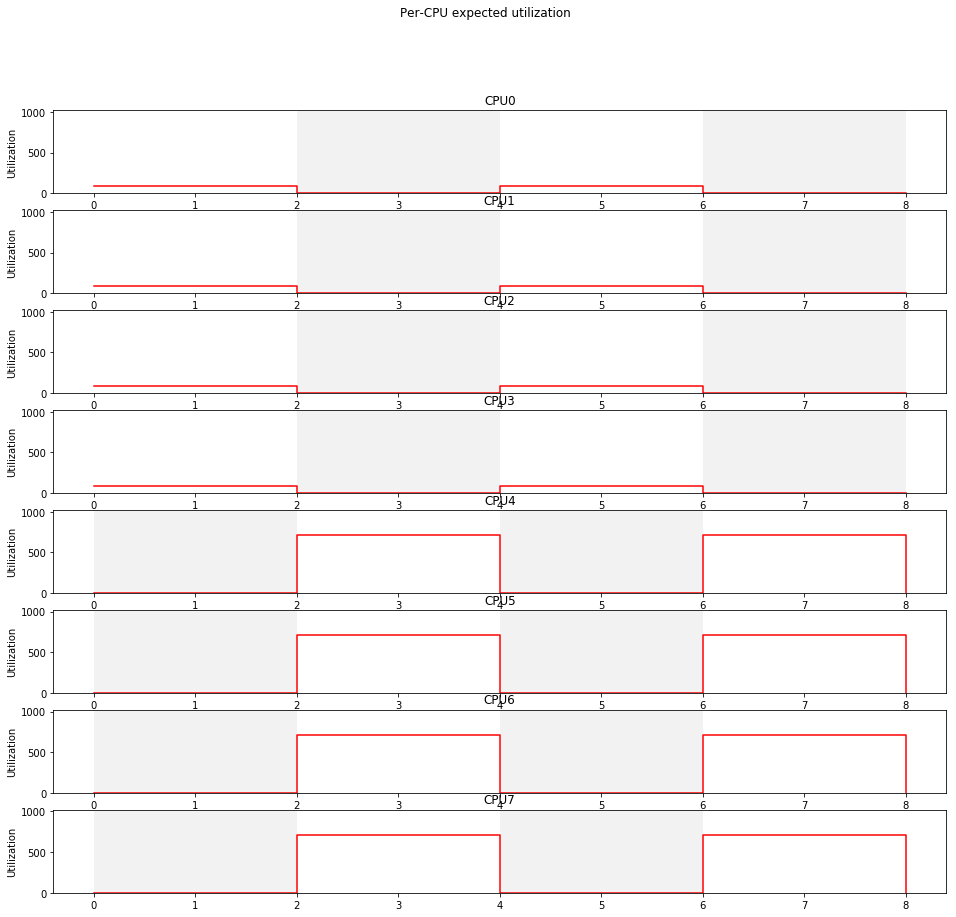

In [11]:
image_path = os.path.join(bundle.res_dir, "expected_placement.png")
Image(image_path)

# Offline replaying

Say someone executed some tests, and ran into some issues. They can create an archive of the results directory and send it your way, and you'll be able to reload it automagically. This also works if you are working on the test code itself, and don't want to re-execute the workload every single time you change the code.

In [12]:
# Let's just reuse what was generated in the previous run
archive_dir = bundle.res_dir

In [13]:
reloaded_bundle = EnergyModelWakeMigration.from_dir(archive_dir)

In [14]:
# Just to prove we're not cheating!
reloaded_bundle == bundle

False

In [15]:
print(reloaded_bundle.test_task_placement())

PASSED: energy threshold=12697.384476751002 bogo-joules, estimated energy=11223.304584691345 bogo-joules
